In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import models
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {DEVICE} for inference')

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using cpu for inference
Num GPUs Available:  1


##### Model Settings #######

In [2]:
RANDOM_SEED = 6
LEARNING_RATE = 0.001
MOMENTUM = 0.9

BATCH_SIZE = 128
NUM_EPOCHS = 10

NUM_INPUTS = 1*28*28 # grayscale (1-channel) 28*28 picture
NUM_CLASSES = 10 # digits 0 to 9

##### Load MNIST Dataset #######

In [3]:
train_data = datasets.MNIST(
    root="dataset",
    train=True,
    download=True,
    transform= transforms.ToTensor()
)

test_data = datasets.MNIST(
    root="dataset",
    train=False,
    download=True,
    transform= transforms.ToTensor()
)

train_loader = DataLoader(dataset=train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_data, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

CLASSES = train_data.classes

In [4]:
torch.manual_seed(RANDOM_SEED) # So we can reproduce same results

resnet18 = models.resnet18(pretrained=True)

print(resnet18.conv1)
print(resnet18.fc)

# we only need 10 classes need to cahnge ouput layer
# we also need to chnage so it takes 1 cahnnel instead of three channels
resnet18.fc = nn.Linear(resnet18.fc.in_features,NUM_CLASSES)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
print()
print(resnet18.conv1)
print(resnet18.fc)

# Make sure to send our model to GPU if available
resnet18 = resnet18.to(DEVICE)

# Create Loss function and Optimizer for training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.fc.parameters(), lr=LEARNING_RATE) # momentum=MOMENTUM

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=512, out_features=1000, bias=True)

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=512, out_features=10, bias=True)


c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Compare True Label w/ Predicted Label #####

In [5]:
def compute_accuracy (model, data_loader, device):
    model = model.to(device)
    model = model.eval() # put the model to evaultion mode
    
    num_correct_prediction = 0
    num_total_labels = 0
    
    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            probabilities = torch.softmax(model(inputs),dim=1)
            predicted_class = torch.argmax(probabilities, dim=1) # Class predicted by model
            
            num_total_labels += labels.size()[0]
            num_correct_prediction += (predicted_class == labels).sum()

    return num_correct_prediction/num_total_labels * 100

#### Test w/o training ####

Predicted Num : 4 w/ probablity : -34.207 %
Actual Num : 2
Total Accuracy on test data : 13.510 %
tensor([4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 4, 4, 1, 1, 1, 1,
        1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1,
        4, 4, 1, 4, 1, 4, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 4,
        1, 1, 1, 1, 1, 4, 1, 4, 4, 1, 4, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4,
        1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        4, 1, 4, 1, 1, 1, 1, 1])


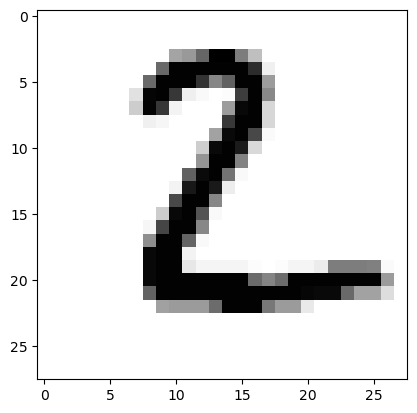

In [11]:
for batch_index, (inputs, labels) in enumerate(test_loader):

    inputs = inputs
    labels = labels
    break
    
    
nhwc_img = np.transpose(inputs[1], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys')
plt.show



resnet18 = resnet18.eval()

with torch.no_grad(): # Save Performance when evaluting or prediciting
    probabilities = resnet18(inputs.to(DEVICE))
    predicted_class = torch.argmax(probabilities, dim=1)

print("Predicted Num : {:d} w/ probablity : {:.3f} %".format(predicted_class[0],probabilities[0][0]*100))
print("Actual Num : {:d}".format(labels[1]))
print("Total Accuracy on test data : {:.3f} %".format(compute_accuracy(resnet18,test_loader,DEVICE)))

# If you got this correct you got very lucky (however your confidence value might be very low) 
# hit run again and you will see the output of the model is just random

#### Train Model ####

In [7]:
import time

def train_model (model, criterion, optimizer, num_epochs, device):
    
    start_time = time.time()
    
    for epochs in range(num_epochs):
        
        # train first
        model.train()
        for batch_index, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            
            print()
            
        
        # evalute
        model.eval() 
    
    return model

In [8]:
#resnet18 = train_model(resnet18,criterion,optimizer,NUM_EPOCHS,DEVICE)

### Test w/ Training ###

Predicted Num : 4 w/ probablity : 6.531 %
Actual Num : 7
Total Accuracy on test data : 13.510 %


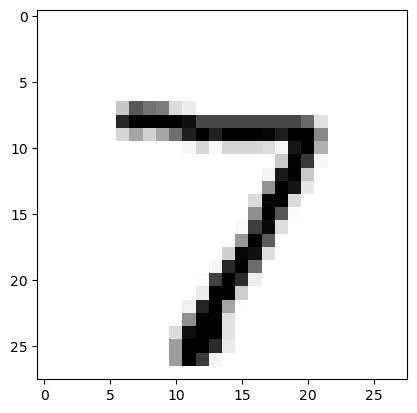

In [9]:
for batch_idx, (inputs, labels) in enumerate(test_loader):

    inputs = inputs
    labels = labels
    break
    
    
nhwc_img = np.transpose(inputs[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys')
plt.show



resnet18 = resnet18.eval()

with torch.no_grad(): # Save Performance when evaluting or prediciting
    probabilities = torch.softmax(resnet18(inputs.to(DEVICE)[0,None]),dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)

print("Predicted Num : {:d} w/ probablity : {:.3f} %".format(predicted_class[0],probabilities[0][0]*100))
print("Actual Num : {:d}".format(labels[0]))
print("Total Accuracy on test data : {:.3f} %".format(compute_accuracy(resnet18,test_loader,DEVICE)))


# If you got this correct you got very lucky (however your confidence value might be very low) 
# hit run again and you will see the output of the model is just random